# Real Feedback For Product-Focused Companies

<b>Authors:</b> John Newcomb, Doug Mill, Andrew Marinelli

## Overview

For large compaines, broad user feedback generally takes on a relatively stiff form: The company issues a feedback survey with some sort of coupon reward for completion, and the user has the option to complete or not complete. There are several problems with this approach. First of all, voluntary feedback often times does not accurate reflect true sentiment. People generally feel the need to be nice, so they do not give their true thoughts. Negative experiences become neutral, neutral experiences become positive, and positive experiences become legendary. 

However, new means of information aggregation enable us to on user feedback in a natural way, where users do not feel surveilled. Using information streams from twitter API, along with an in-house contructed sentiment analysis tool, we aim to provide real-time tweet flagging for companies interested in getting synchronous honest feedback on their products. Equipped with the ability to sift through piles of tweets at an accelerated pace, UX and customer success teams will be enabled to iterate faster on their products, which leads to a better overall product, service, and overall company. 

## Business Understanding

Gathering user feedback can be both difficult and deceiving. Additionally, tracking down and tackling bad PR has always been anything but predictable. However, in the digital age, we are able to monitor social media sites for indications of bad press. The idea is simple: Hook up to the twitter API, search for tweets related to your company via keyword (so, for exmaple, Apple might be interested in any tweet containing "iPad", "iPhone", etc), then have your user experience team sort through them as to identify strengths and weaknesses in the copmany. However, with the application of NLP, it is actually possible not only to bin the tweets but also to analyse them for sentiment. The implication of this is that a user experience team could get a constant stream of information regarding the shortcoming of their product, enabling more rapid iterations to solve UX challenges and quicker responses to mitigate customer dissatisfaction. The overall result: decreased customer churn, increased user experience team productivity, which, as you might guess, leads to overall increase in bottom line revenues, not to mention a better overall company.

## Data Understanding

We gathered our data from the 2013 South by Southwest festival in Austin, TX. The tweets themselves are sourced by hashtag, meaning that this is a collection of tweets that specifically mention "#sxsw" or a close variant. The dataset has three colunms. Each row contains a tweet, the product that tweet is directed at, and the emotion in that tweet. The emotion was determined on a tweet-by-tweet basis from a group of voters. In the case that the voters agreed on the emotion in the tweet, it was labeled either positive, negative, or neutral; in the case that there was no agreement, the tweet was labeled as indeterminable. 

## Methodology

How did we do it? We begin with the aforementioned dataset of tweets from South By Southwest 2013, a popular music festival in Austin, TX, where high tech companies make a habit of appearing to flaunt their latest and trendiest updates. First, we generate metadata per tweet, and clean the tweet overall as to exclude non-sense characters as well as other text portions irrelevant to sentiment determination. Next, we go through an iterative modeling process, agreeing on a model per pre-established metric evaulation. Finally, we cross validate our results, and eventually test our product on unseen data to confirm our results. 

## EDA

We will begin with the basic necessary EDA.

In [142]:
# import necessary packages
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

import string
import re

from sklearn.feature_extraction.text import CountVectorizer

import nltk
nltk.download('wordnet')

<ipython-input-142-c09b5d635a8c>:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/westonnewcomb/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Let's take a look at what we're working with!

In [143]:
# load data in as pandas DataFrame object
df = pd.read_csv('data/data.csv', encoding='unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


Our data appears to consist of three columns, each relatively simple to understand. Our first data is a tweet, followed by the product at which the tweet is directed, and finally the sentiment of that tweet. 

Before we go any further, let's go ahead and rename the columns for the sake of simplicity. 

In [144]:
# rename columns for simplicity
columns_dict = {'tweet_text':'tweet',
                'emotion_in_tweet_is_directed_at':'product',
                'is_there_an_emotion_directed_at_a_brand_or_product':'emotion_response'}

df = df.rename(columns=columns_dict)

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet             9092 non-null   object
 1   product           3291 non-null   object
 2   emotion_response  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


Apparently we are missing some values...

In [146]:
df.isna().sum()

tweet               1   
product             5802
emotion_response    0   
dtype: int64

Before we deal with this nightmare of a situation with the product column, let's take a look at the null-valued tweet.

In [147]:
df[df['tweet'].isna()]

,tweet,product,emotion_response
6,NaN,NaN,No emotion toward brand or product


This appears likely to be a data input error. We can drop that row from the dataset. 

In [148]:
df = df.dropna(subset=['tweet'])

Shall we take a look at the product column next?

In [149]:
df['product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                        81 
Android                            78 
Other Apple product or service     35 
Name: product, dtype: int64

In [150]:
df['product'].isna().mean()

0.6380334359876815

It appears as though we are do not have much information about the products - we're missing values in nearly two-thirds of the rows in the 'product' column. Perhaps this is a mistake in the dataset. In order to circumvent this issue, let's fill in the values if the tweet contains words indicative of the company involved. Additionally, we are not particularly concerned with particular products as opposed to their respective companies. 

In [151]:
apple_words = ['iphone', 'ipad', 'apple']
google_words = ['google', 'android']

In [152]:
def brand_classifier(tweet):
    
    tweet = tweet.lower()
    
    google = any(g in tweet for g in google_words)
    apple = any(a in tweet for a in apple_words)
    
    if (apple & google):
        return 'both'
    elif apple:
        return 'apple'
    elif google:
        return 'google'
    else:
        return 'neither'

In [153]:
df['company'] = df['tweet'].map(lambda x: brand_classifier(x))

In [154]:
df['company'].value_counts()

apple      5275
google     2781
neither    786 
both       250 
Name: company, dtype: int64

Wow - significantly better. Let's take a closer look at our emotions column now.

In [155]:
df['emotion_response'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                      570 
I can't tell                          156 
Name: emotion_response, dtype: int64

First, we should drop those values which contain "I can't tell" values because we cannot truly know what the emotion is. To reiterate, the response "I can't tell" corresponds to an event in which the group of people classifying the tweet voted in an even split. 

In [156]:
df = df[df['emotion_response'] != 'I can\'t tell']

Since we are only interested in classifying negative vs. non-negative, let's reframe our data so that it only contains information about whether the tweet has negative sentiment or not. 

In [157]:
emotions_dict = {'Positive emotion':0,
                 'No emotion toward brand or product':0,
                 'Negative emotion':1}

df['sentiment'] = df['emotion_response'].replace(emotions_dict)

#### look into i cant tell columns

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8936 entries, 0 to 9092
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet             8936 non-null   object
 1   product           3282 non-null   object
 2   emotion_response  8936 non-null   object
 3   company           8936 non-null   object
 4   sentiment         8936 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 418.9+ KB


In [159]:
df['sentiment'].value_counts()

0    8366
1    570 
Name: sentiment, dtype: int64

In [160]:
df['sentiment'].mean()

0.06378692927484333

So we are most certainly dealing with a case of class imbalance, which means almost definitely that we will need to upsample or downsample our data. Also, we should definitely be evaluating our models based on a metric different than accuracy. In the mean time, we'll drop the columns that are not necessary for our purposes.

In [161]:
df = df.drop(['product', 'emotion_response'], axis=1)

For our final preprocessing step, it is necessary to clean the tweet of all unnecessary characters. We will use this function later on in a pipeline, so that we can scale for deployment later more efficiently. 

In [162]:
def tweet_cleaner(tweet):
    twtr_stopwords = ['rt','rts','retweet','quot','sxsw', 'amp']
    punctuation = set(string.punctuation)
    punctuation.remove('#')
    
    x = tweet
    x = re.sub(r'https?:\/\/\S+', '', x) #remove URLs
    x = re.sub(r'{link}', '', x) #placeholders
    x = re.sub(r'@[\w]*', '', x) #@mention users
    x = re.sub('[^A-Za-z0-9]+', ' ', x) #@mention users
    x = re.sub(r'\b[0-9]+\b', '', x) #remove stand-alone numbers
    x = re.sub(r'&[a-z]+;', '', x) #remove HTML ref chars
    x = re.sub(r'\d+', '', x) #removes all NUMERALS
    x = ''.join(ch for ch in x if ch not in punctuation) #remove punctuation
    x = x.replace("[^a-zA-z]#", " ") #remove special chars
    
    x = [word.lower() for word in x.split() if word.lower() not in twtr_stopwords]
    x = [w for w in x if len(w)>2]
    
    lemmatizer = nltk.stem.WordNetLemmatizer()
    
    x = [lemmatizer.lemmatize(token) for token in x]
    
    return x

## Modeling

We will start the modeling process by, like always, breaking our data into train and test sets.

In [117]:
# import necessary outside modules for modeling purposes
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn import pipeline
from xgboost import XGBClassifier

In [27]:
# split full DataFrame into train and test sets
X = df['tweet']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

Additionally, let's go ahead and create a function for evaluation model performance. 

In [43]:
def eval_model(model, X_train, X_test, y_train, y_test):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    plot_confusion_matrix(model, X_test, y_test)
    print(classification_report(y_test, y_pred))

### Baseline

We'll start our moedling process by establishing a baseline with a Decision Tree model from sklearn. 

In [92]:
dt_pipe = pipeline.Pipeline(steps=[('pre',CountVectorizer(lowercase=False,
                                                                tokenizer=tweet_cleaner)),
                                         ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
                                         ('dt', DecisionTreeClassifier(random_state=42))])

dt_cv = cross_validate(estimator=dt_pipe, X=X_train, y=y_train,
                       scoring='recall', cv=5, n_jobs=-1)

dt_cv

{'fit_time': array([0.88397217, 0.85496998, 0.87282681, 0.86352277, 1.91616011]),
 'score_time': array([0.12428594, 0.12380195, 0.124403  , 0.12416005, 0.10367393]),
 'test_score': array([0.54117647, 0.37209302, 0.39534884, 0.43023256, 0.29411765])}

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      2131
           1       0.17      0.40      0.24       142

    accuracy                           0.84      2273
   macro avg       0.56      0.63      0.57      2273
weighted avg       0.91      0.84      0.87      2273



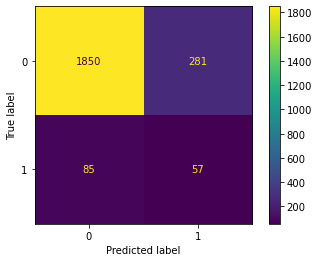

In [93]:
eval_model(dt_pipe, X_train, X_test, y_train, y_test)

As we may have expected, our baseline accuracy is relatively high while our precision and recall are both somewhat low for our target. But this model is most likely disastrously overfitting also - so we need to be careful. However, we have established that we can - to some degree of proficiency - determine the sentiment of a tweet! Let's adjust some of the parameters and see if we can imporve off of our baseline. 

In [95]:
dt_pipe_2 = pipeline.Pipeline(steps=[('pre',CountVectorizer(lowercase=False,
                                                                tokenizer=tweet_cleaner)),
                                         ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
                                         ('dt', DecisionTreeClassifier(class_weight={0:100, 1:1},
                                                                       random_state=42))])

dt_cv = cross_validate(estimator=dt_pipe_2, X=X_train, y=y_train,
                       scoring='recall', cv=5, n_jobs=-1)

dt_cv

{'fit_time': array([1.16735983, 1.17789888, 1.17913699, 1.19119716, 1.2029078 ]),
 'score_time': array([0.14501619, 0.14370012, 0.13922524, 0.13836288, 0.12935233]),
 'test_score': array([0.55294118, 0.45348837, 0.41860465, 0.53488372, 0.42352941])}

              precision    recall  f1-score   support

           0       0.96      0.83      0.89      2131
           1       0.16      0.48      0.24       142

    accuracy                           0.81      2273
   macro avg       0.56      0.65      0.56      2273
weighted avg       0.91      0.81      0.85      2273



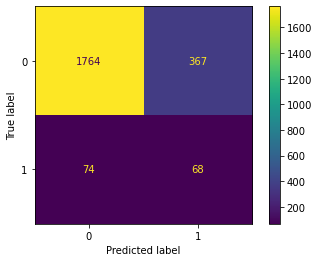

In [96]:
eval_model(dt_pipe_2, X_train, X_test, y_train, y_test)

Our recall is significantly improved. Since we are willing to sacrifice accuracy and precision for recall, we can say that we have improved on our original model. 

### Random Forest

In [101]:
rf_pipe = pipeline.Pipeline(steps=[('pre', CountVectorizer(lowercase=False, 
                                                           tokenizer=tweet_cleaner,
                                                           max_features=100)),
                                   ('smote', SMOTE(random_state=42)),
                                   ('rf', RandomForestClassifier(random_state=42, 
                                                                 class_weight={0:1,
                                                                               1:10}))])

rf_cv = cross_validate(estimator=rf_pipe, X=X_train, y=y_train, 
                       scoring='recall', cv=5, n_jobs=-1)

rf_cv

{'fit_time': array([3.43784714, 3.34204912, 3.43404889, 3.42933679, 3.3979671 ]),
 'score_time': array([0.16742086, 0.16254091, 0.16220403, 0.15989232, 0.15930796]),
 'test_score': array([0.37647059, 0.34883721, 0.29069767, 0.38372093, 0.32941176])}

              precision    recall  f1-score   support

           0       0.95      0.84      0.90      2131
           1       0.14      0.37      0.20       142

    accuracy                           0.81      2273
   macro avg       0.54      0.61      0.55      2273
weighted avg       0.90      0.81      0.85      2273



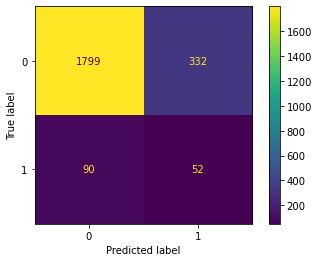

In [102]:
eval_model(rf_pipe, X_train, X_test, y_train, y_test)

Not as good as we might have hoped, although our RF is probably not overfitting as much as our decision tree. 

### XGBoost

In [113]:
x = XGBClassifier

In [118]:
xgb_pipe = pipeline.Pipeline(steps=[('pre', CountVectorizer(lowercase=False, 
                                                           tokenizer=tweet_cleaner,
                                                           max_features=100)),
                                   ('smote', SMOTE(random_state=42)),
                                   ('xgb', XGBClassifier())])

xgb_cv = cross_validate(estimator=xgb_pipe, X=X_train, y=y_train, 
                       scoring='recall', cv=5, n_jobs=-1)

xgb_cv

{'fit_time': array([2.80946183, 2.82124209, 2.82116985, 2.80832982, 2.8033669 ]),
 'score_time': array([0.13659024, 0.12957978, 0.13020325, 0.13036203, 0.12808299]),
 'test_score': array([0.16470588, 0.08139535, 0.09302326, 0.11627907, 0.12941176])}

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2131
           1       0.22      0.08      0.11       142

    accuracy                           0.93      2273
   macro avg       0.58      0.53      0.54      2273
weighted avg       0.90      0.93      0.91      2273



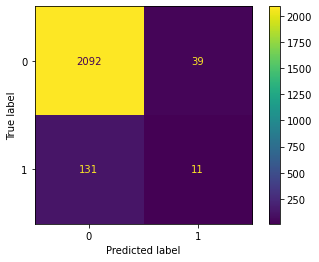

In [119]:
eval_model(xgb_pipe, X_train, X_test, y_train, y_test)

## Evaluation

Based on our three models, we can conclude that our second decision tree should work the best in production. This is because it has the highest recall rate. To understand why recall rate is our chosen metric, you have to imagine the workflow of a user of this software. Because the cost associated with flagging a positive tweet as negative is relatively low (3 seconds off of a person's work stack to recognize that the software was incorrect on this occasion), we are willing to give up accuracy if more dexterity in flagging negative tweets overall entails. 

## Conclusion

While we did come up with a decent solution, there is still a great deal of work to do in the way of model optimization and deplyment. We did not use gridsearch; we did not do a large amount of feature engineering; we did not gain as intuitive an understanding of our dataset as we would have liked.

## Future Research

Future research should be conducted on a variety of fronts. Firstly, we will experiment with pre-made neural nets and other algorithms, which are significantly better at classfying tweets and conducting NLP processes. Secondly, we need to deploy our model on real world data for proof of concept, especially in a CI/CD environment. Thirdly, our team plans to gather a larger amount of data per tweet, so that we can better understand other items such as tweet activity (RTs, favorites, replies, other metrics of tweet attention), and account metrics (how many followers does this person have, what is this person's general tweet engagement on average, etc.). The direction of our work aims to inform UX and customer success teams on how they can better manage their products to maximize performance; thus, feedback through other social media sites could also be helpful, especially where more than 280 characters can provide a more precise explanation of user frustrations. 